In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import dynesty as dyn

In [2]:
err_grb = []
for i in range(1, 4):
    with open('aefit'+ str(i) +'.out', 'rb') as f:
        temp = f.read().decode('utf-8').split('\n')
        for t in temp:
            if 'Error plotting fits for ' in t:
                err_grb.append(t.split('Error plotting fits for ')[1].split('\n')[0])    

In [3]:
err_grb

[]

In [4]:
len(err_grb)

0

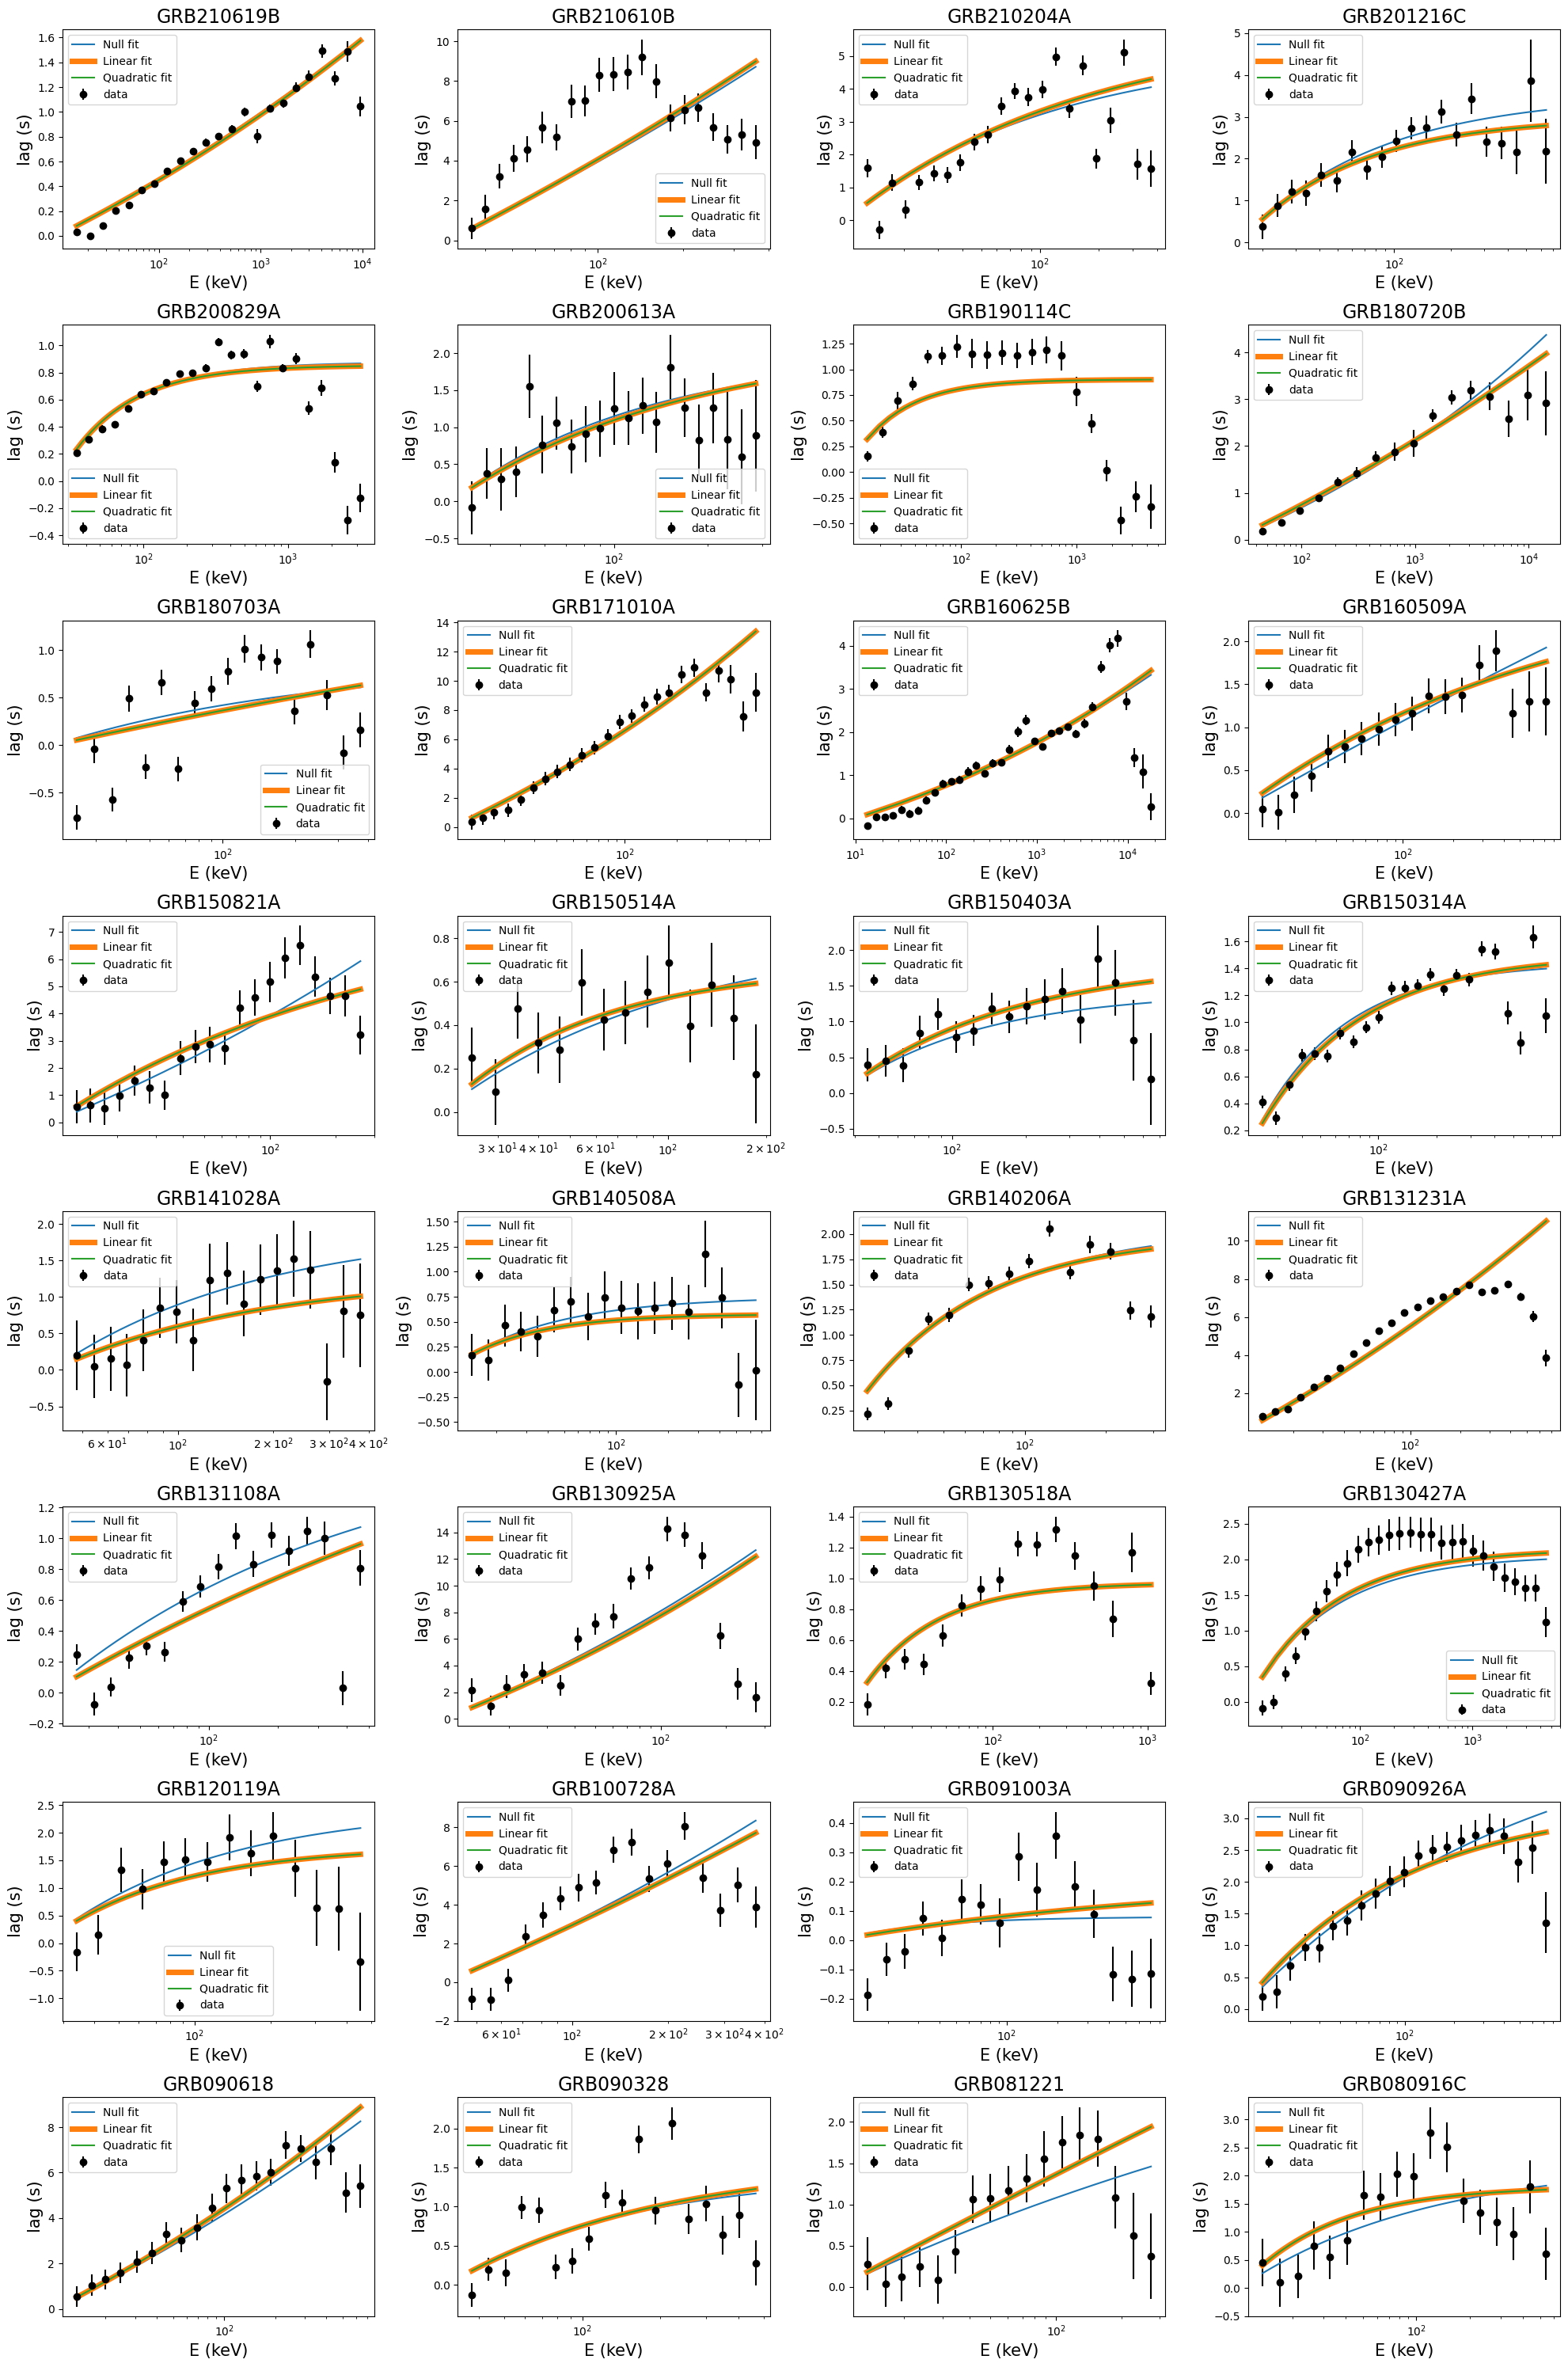

In [5]:
fig, ax = plt.subplots(8, 4, figsize=(20, 30))
GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']
err_grb = GRBs
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)
for grb in err_grb:
    
    
    grbname = grb + '.txt'
    grbname_wtht_ext = grbname.replace('.txt','')


    arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
    data = [arr[:,0], arr[:,1], arr[:,2]]
    x = arr[:,0]
    y = arr[:,1]
    yerr = arr[:,2]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    H0=67.36 #Hubble constant km -1 Mpc s -1
    omega_m = 0.315
    omega_l = 1 - omega_m
    grb
    #MODELS

    #NULL model
    def nullhp(E, alpha, tau):
        return (1 + z_com)*(tau * ((E ** alpha) - (E0 ** alpha)))
        


    def int_z(z_prime, n):
        integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
        return quad( integ_fn, a=0, b=z_prime)[0]

    int_z1 = np.asarray(int_z(z_com, 1))
    int_z2 = np.asarray(int_z(z_com, 2))

    #LINEAR model
    def linearhp(E, logEqg, alpha, tau):
        
        e0qg = (E - E0) / (10 ** logEqg)
        
        return - (e0qg * int_z1)/H0 + nullhp(E, alpha, tau)

    #QUADRATIC model
    def quadhp(E, logEqg, alpha, tau):
        e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
        
        return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, alpha, tau)
    #LOG-LIKELIHOODS
    def loglike_null(theta):
        alpha, tau = theta
        
        
        model = nullhp(x,  alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
        
        

    def loglike_linear(theta):
        logEqg, alpha, tau = theta
        
        model = linearhp(x, logEqg, alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

    def loglike_quad(theta):
        logEqg, alpha, tau = theta
        
        model = quadhp(x, logEqg, alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))


    alphamin = -1
    alphamax = 1
    taumin = -10
    taumax = 10
    logeqmin = 6
    logeqmax = 19
    #PRIOR DISTRIBUTIONS

    def prior_transform_null(theta):
        alpha, tau = theta
        return [(alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    def prior_transform_linear(theta):
        logEqg, alpha, tau = theta
        return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    def prior_transform_quadratic(theta):
        logEqg, alpha, tau = theta
        return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    threesamplers = ['_null_sampler.pkl', '_linear_sampler.pkl', '_quadratic_sampler.pkl']
    sampler0 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[0])
    sampler1 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[1])
    sampler2 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[2])
    results0 = sampler0.results
    results1 = sampler1.results
    results2 = sampler2.results

    #PLOTTING FITS

    nplot = 1000
    E = np.linspace(min(Erest), max(Erest), nplot)
    samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
    # samples0 = np.median(samples0, axis=0)
    samples0 = samples0[np.argmax(results0.logl)]

    samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
    # samples1 = np.median(samples1, axis=0)
    samples1 = samples1[np.argmax(results1.logl)]

    samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
    # samples2 = np.median(samples2, axis=0)
    samples2 = samples2[np.argmax(results2.logl)]
    null_fit = [nullhp(E[i], samples0[0], samples0[1]) for i in range(nplot)]
    liv_lin_fit = [linearhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]
    liv_quad_fit = [quadhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]

    
    
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].plot(E, null_fit, label='Null fit')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].plot(E, liv_lin_fit,label='Linear fit', lw=5)
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].plot(E, liv_quad_fit, label='Quadratic fit')
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_xscale('log')
    # ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_ylim(min(y) - max(abs(yerr)) - 10, max(y) + max(abs(yerr)) + 10)
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].legend()
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_xlabel('E (keV)', fontsize=15)
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_ylabel('lag (s)', fontsize=15)
    ax[err_grb.index(grb)//4, err_grb.index(grb)%4].set_title(grb, fontsize=17)
    
    

    

plt.tight_layout()
# plt.suptitle('Agarwal et al. 2021 fits\n\n', y=1.0)
plt.savefig('./outputs/fits/AWL_etal_all32.pdf', facecolor='white', format='pdf')
plt.show()

[0, 0]
Null fit chi2/dof:  22.991611575336528
Linear fit chi2/dof:  24.188650952508812
Quadratic fit chi2/dof:  24.232290485957503

[0, 1]
Null fit chi2/dof:  75.40937445343182
Linear fit chi2/dof:  78.99402515200819
Quadratic fit chi2/dof:  78.95810301194362

[1, 0]
Null fit chi2/dof:  8.557835133908094
Linear fit chi2/dof:  9.033851046669184
Quadratic fit chi2/dof:  9.024321219814103

[1, 1]
Null fit chi2/dof:  20.358912736202743
Linear fit chi2/dof:  21.974659398212854
Quadratic fit chi2/dof:  21.729125180618468



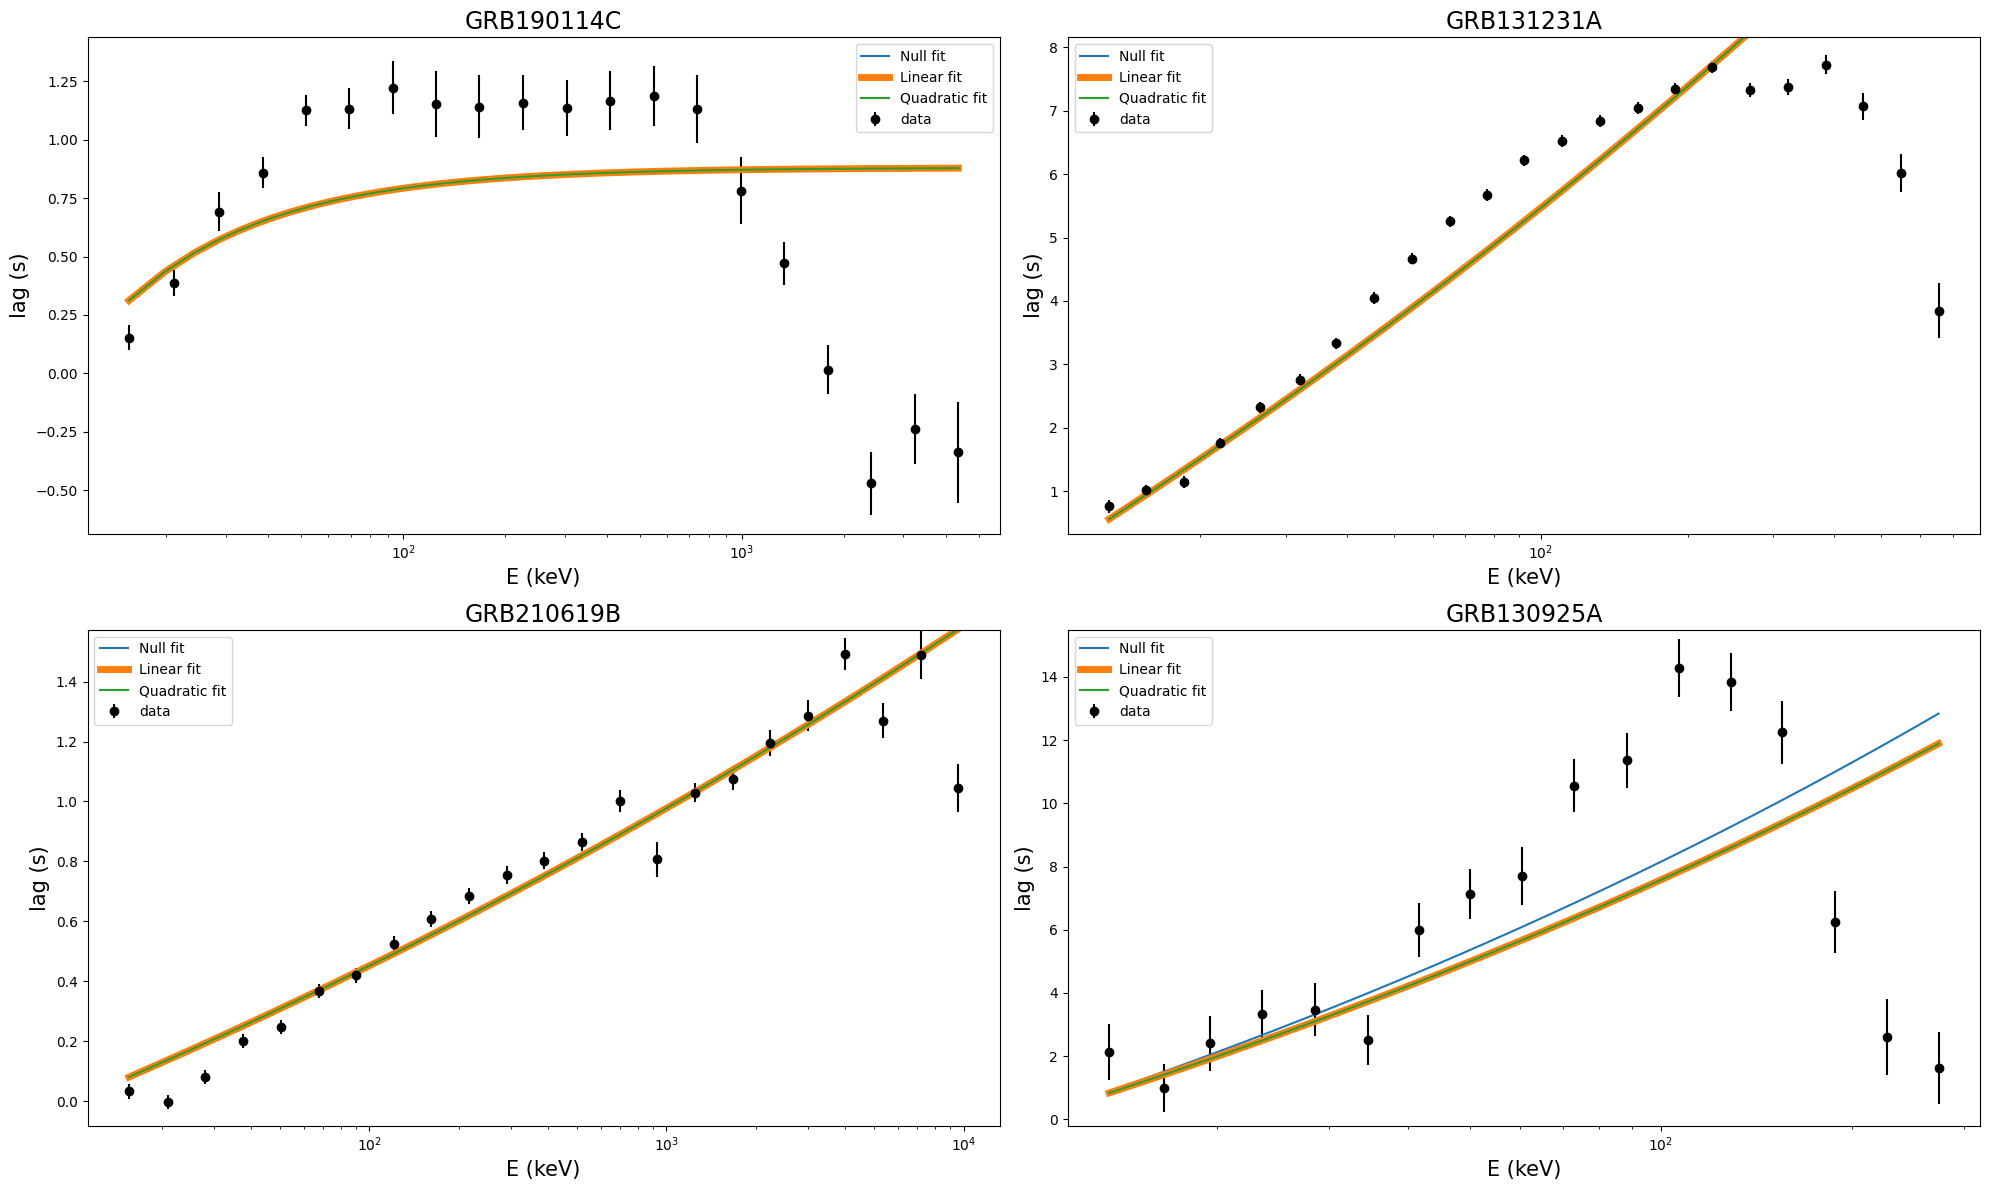

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']
# err_grb = GRBs
err_grb = ['GRB190114C', 'GRB131231A', 'GRB210619B', 'GRB130925A']
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)
for grb in ['GRB190114C', 'GRB131231A', 'GRB210619B', 'GRB130925A']:
    
    
    grbname = grb + '.txt'
    grbname_wtht_ext = grbname.replace('.txt','')


    arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
    data = [arr[:,0], arr[:,1], arr[:,2]]
    x = arr[:,0]
    y = arr[:,1]
    yerr = arr[:,2]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    H0=67.36 #Hubble constant km -1 Mpc s -1
    omega_m = 0.315
    omega_l = 1 - omega_m
    grb
    #MODELS

    #NULL model
    def nullhp(E, alpha, tau):
        return (1 + z_com)*(tau * ((E ** alpha) - (E0 ** alpha)))
        


    def int_z(z_prime, n):
        integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
        return quad( integ_fn, a=0, b=z_prime)[0]

    int_z1 = np.asarray(int_z(z_com, 1))
    int_z2 = np.asarray(int_z(z_com, 2))

    #LINEAR model
    def linearhp(E, logEqg, alpha, tau):
        
        e0qg = (E - E0) / (10 ** logEqg)
        
        return - (e0qg * int_z1)/H0 + nullhp(E, alpha, tau)

    #QUADRATIC model
    def quadhp(E, logEqg, alpha, tau):
        e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
        
        return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, alpha, tau)
    #LOG-LIKELIHOODS
    def loglike_null(theta):
        alpha, tau = theta
        
        
        model = nullhp(x,  alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
        
        

    def loglike_linear(theta):
        logEqg, alpha, tau = theta
        
        model = linearhp(x, logEqg, alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

    def loglike_quad(theta):
        logEqg, alpha, tau = theta
        
        model = quadhp(x, logEqg, alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))


    alphamin = -1
    alphamax = 1
    taumin = -10
    taumax = 10
    logeqmin = 6
    logeqmax = 19
    #PRIOR DISTRIBUTIONS

    def prior_transform_null(theta):
        alpha, tau = theta
        return [(alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    def prior_transform_linear(theta):
        logEqg, alpha, tau = theta
        return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    def prior_transform_quadratic(theta):
        logEqg, alpha, tau = theta
        return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    threesamplers = ['_null_sampler.pkl', '_linear_sampler.pkl', '_quadratic_sampler.pkl']
    sampler0 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[0])
    sampler1 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[1])
    sampler2 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[2])
    results0 = sampler0.results
    results1 = sampler1.results
    results2 = sampler2.results

    #PLOTTING FITS

    nplot = 1000
    E = np.linspace(min(Erest), max(Erest), nplot)
    samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
    # samples0 = np.median(samples0, axis=0)
    samples0 = samples0[np.argmax(results0.logl)]

    samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
    # samples1 = np.median(samples1, axis=0)
    samples1 = samples1[np.argmax(results1.logl)]

    samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
    # samples2 = np.median(samples2, axis=0)
    samples2 = samples2[np.argmax(results2.logl)]
    null_fit = [nullhp(E[i], samples0[0], samples0[1]) for i in range(nplot)]
    liv_lin_fit = [linearhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]
    liv_quad_fit = [quadhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]



    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].plot(E, null_fit, label='Null fit')
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].plot(E, liv_lin_fit,label='Linear fit', lw=5)
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].plot(E, liv_quad_fit, label='Quadratic fit')
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_xscale('log')
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_ylim(min(y) - max(abs(yerr)), max(y) + max(abs(yerr)))
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].legend()
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_xlabel('E (keV)', fontsize=15)
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_ylabel('lag (s)', fontsize=15)
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_title(grb, fontsize=17)
    print([err_grb.index(grb)//2, err_grb.index(grb)%2 ])
    def chi2_gof(x, y, yerr, fit_func, *fit_func_args):
        
        return np.sum(((y - fit_func(x, *fit_func_args))/yerr)**2)/(len(y) - len(fit_func_args))


    gof_null = chi2_gof(Erest, y, yerr, nullhp, samples0[0], samples0[1])
    gof_lin = chi2_gof(Erest, y, yerr, linearhp, samples1[0], samples1[1], samples1[2])
    gof_quad = chi2_gof(Erest, y, yerr, quadhp, samples2[0], samples2[1], samples2[2])
    print('Null fit chi2/dof: ', gof_null)
    print('Linear fit chi2/dof: ', gof_lin)
    print('Quadratic fit chi2/dof: ', gof_quad)
    print()

    

plt.tight_layout()
# plt.suptitle('Agarwal et al. 2021 fits\n\n', y=1.0)
# plt.savefig('./outputs/fits/AWL_etal_all32.pdf', facecolor='white', format='pdf')
plt.show()

[0, 0]
Null fit chi2/dof:  22.90912954301398
Linear fit chi2/dof:  24.261400987338558
Quadratic fit chi2/dof:  24.259128365496558

[0, 1]
Null fit chi2/dof:  75.22713835905486
Linear fit chi2/dof:  78.98480308742755
Quadratic fit chi2/dof:  78.98194769920445

[1, 0]
Null fit chi2/dof:  8.550730108056102
Linear fit chi2/dof:  8.990765320818513
Quadratic fit chi2/dof:  8.984348022843989

[1, 1]
Null fit chi2/dof:  20.19139517515629
Linear fit chi2/dof:  21.63467468602189
Quadratic fit chi2/dof:  21.634025464488065



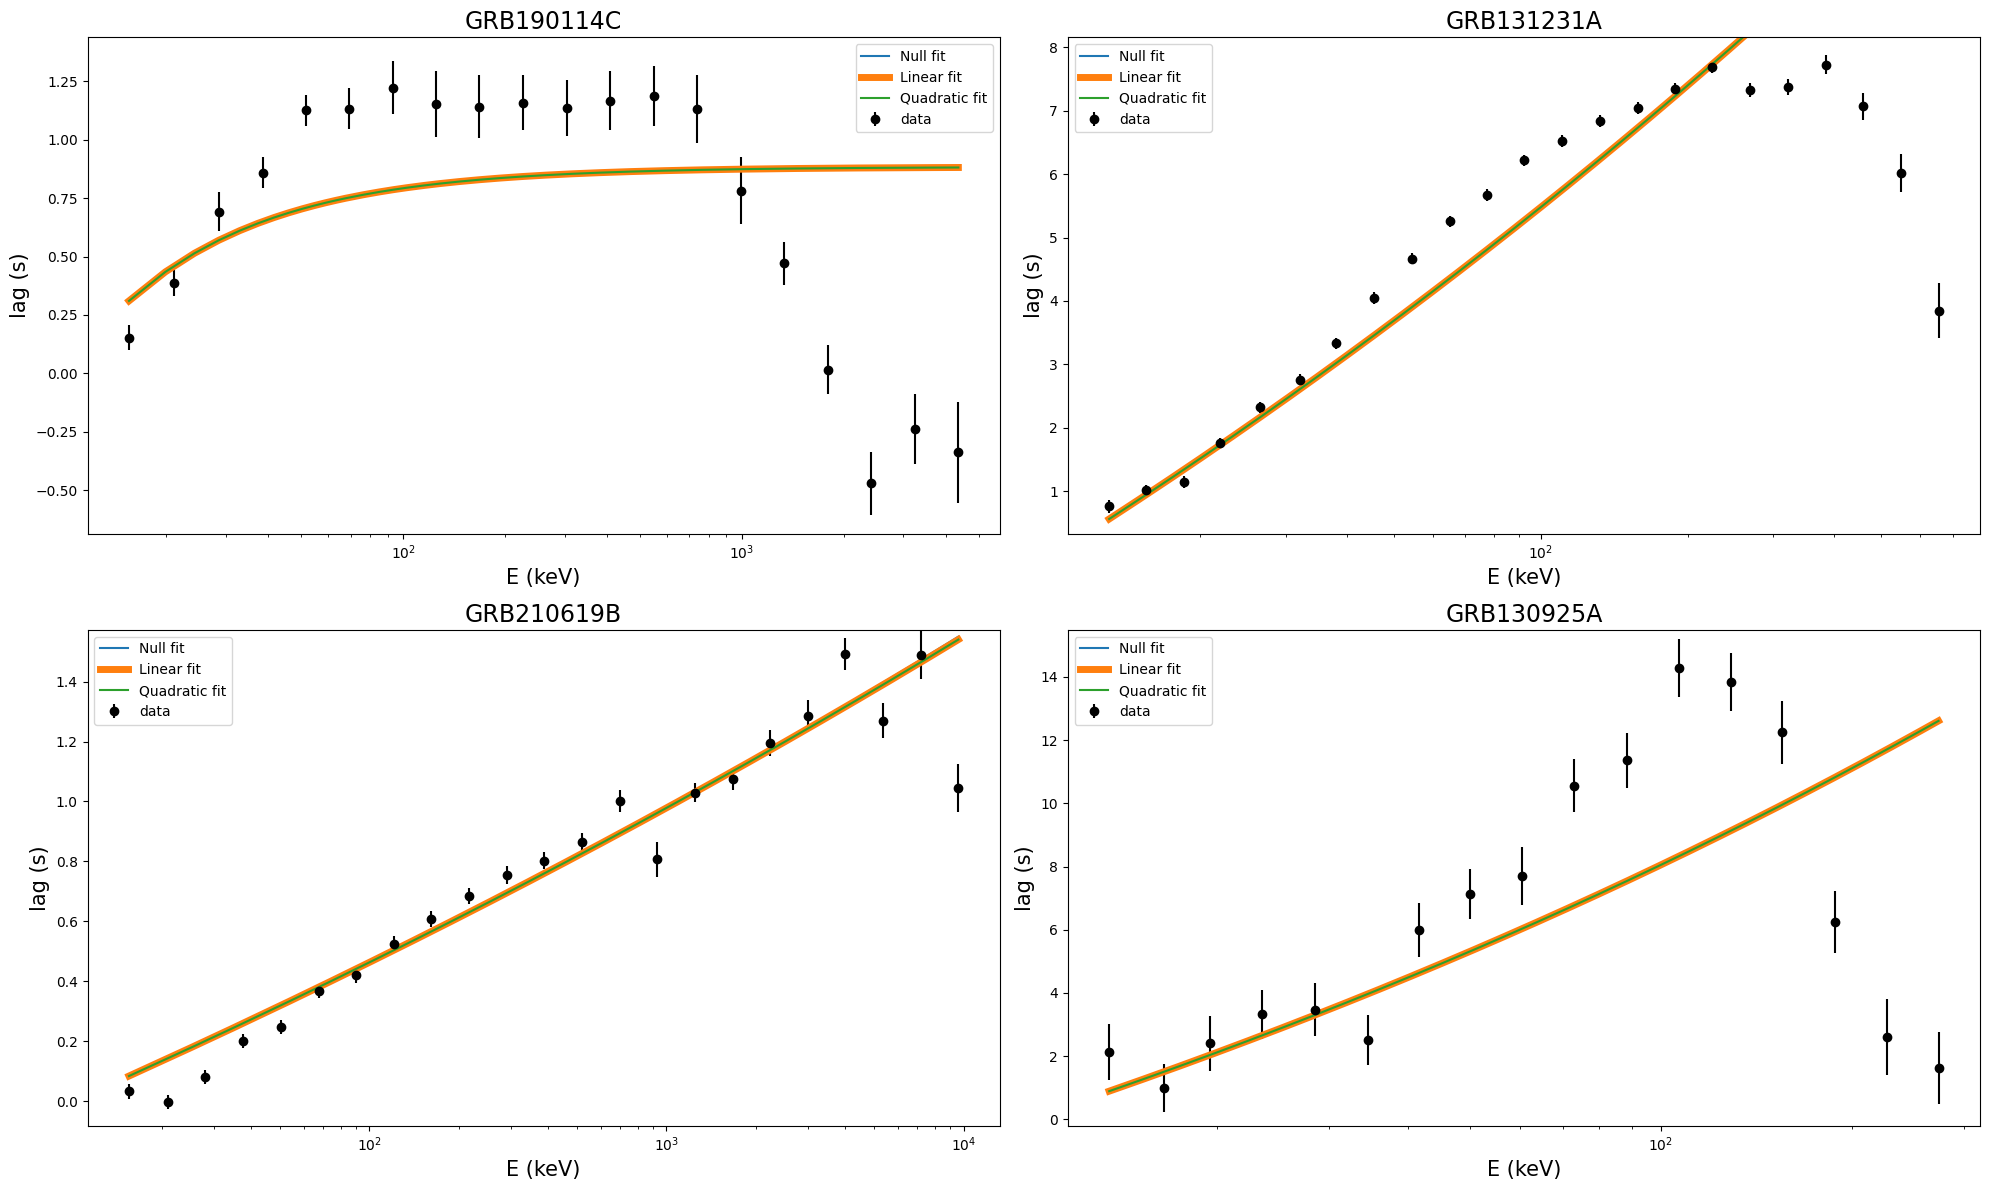

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']
# err_grb = GRBs
err_grb = ['GRB190114C', 'GRB131231A', 'GRB210619B', 'GRB130925A']
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)
for grb in ['GRB190114C', 'GRB131231A', 'GRB210619B', 'GRB130925A']:
    
    
    grbname = grb + '.txt'
    grbname_wtht_ext = grbname.replace('.txt','')


    arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
    data = [arr[:,0], arr[:,1], arr[:,2]]
    x = arr[:,0]
    y = arr[:,1]
    yerr = arr[:,2]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    H0=67.36 #Hubble constant km -1 Mpc s -1
    omega_m = 0.315
    omega_l = 1 - omega_m
    grb
    #MODELS

    #NULL model
    def nullhp(E, alpha, tau):
        return (1 + z_com)*(tau * ((E ** alpha) - (E0 ** alpha)))
        


    def int_z(z_prime, n):
        integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
        return quad( integ_fn, a=0, b=z_prime)[0]

    int_z1 = np.asarray(int_z(z_com, 1))
    int_z2 = np.asarray(int_z(z_com, 2))

    #LINEAR model
    def linearhp(E, logEqg, alpha, tau):
        
        e0qg = (E - E0) / (10 ** logEqg)
        
        return - (e0qg * int_z1)/H0 + nullhp(E, alpha, tau)

    #QUADRATIC model
    def quadhp(E, logEqg, alpha, tau):
        e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
        
        return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, alpha, tau)
    #LOG-LIKELIHOODS
    def loglike_null(theta):
        alpha, tau = theta
        
        
        model = nullhp(x,  alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
        
        

    def loglike_linear(theta):
        logEqg, alpha, tau = theta
        
        model = linearhp(x, logEqg, alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

    def loglike_quad(theta):
        logEqg, alpha, tau = theta
        
        model = quadhp(x, logEqg, alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))


    alphamin = -1
    alphamax = 1
    taumin = -10
    taumax = 10
    logeqmin = 6
    logeqmax = 19
    #PRIOR DISTRIBUTIONS

    def prior_transform_null(theta):
        alpha, tau = theta
        return [(alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    def prior_transform_linear(theta):
        logEqg, alpha, tau = theta
        return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    def prior_transform_quadratic(theta):
        logEqg, alpha, tau = theta
        return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    threesamplers = ['_null_sampler.pkl', '_linear_sampler.pkl', '_quadratic_sampler.pkl']
    sampler0 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[0])
    sampler1 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[1])
    sampler2 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[2])
    results0 = sampler0.results
    results1 = sampler1.results
    results2 = sampler2.results

    #PLOTTING FITS

    nplot = 1000
    E = np.linspace(min(Erest), max(Erest), nplot)
    samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
    samples0 = np.median(samples0, axis=0)
    # samples0 = samples0[np.argmax(results0.logl)]

    samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
    samples1 = np.median(samples1, axis=0)
    # samples1 = samples1[np.argmax(results1.logl)]

    samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
    samples2 = np.median(samples2, axis=0)
    # samples2 = samples2[np.argmax(results2.logl)]
    null_fit = [nullhp(E[i], samples0[0], samples0[1]) for i in range(nplot)]
    liv_lin_fit = [linearhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]
    liv_quad_fit = [quadhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]



    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].plot(E, null_fit, label='Null fit')
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].plot(E, liv_lin_fit,label='Linear fit', lw=5)
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].plot(E, liv_quad_fit, label='Quadratic fit')
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_xscale('log')
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_ylim(min(y) - max(abs(yerr)), max(y) + max(abs(yerr)))
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].legend()
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_xlabel('E (keV)', fontsize=15)
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_ylabel('lag (s)', fontsize=15)
    ax[err_grb.index(grb)//2, err_grb.index(grb)%2 ].set_title(grb, fontsize=17)
    print([err_grb.index(grb)//2, err_grb.index(grb)%2 ])
    def chi2_gof(x, y, yerr, fit_func, *fit_func_args):
        
        return np.sum(((y - fit_func(x, *fit_func_args))/yerr)**2)/(len(y) - len(fit_func_args))


    gof_null = chi2_gof(Erest, y, yerr, nullhp, samples0[0], samples0[1])
    gof_lin = chi2_gof(Erest, y, yerr, linearhp, samples1[0], samples1[1], samples1[2])
    gof_quad = chi2_gof(Erest, y, yerr, quadhp, samples2[0], samples2[1], samples2[2])
    print('Null fit chi2/dof: ', gof_null)
    print('Linear fit chi2/dof: ', gof_lin)
    print('Quadratic fit chi2/dof: ', gof_quad)
    print()
    

plt.tight_layout()
# plt.suptitle('Agarwal et al. 2021 fits\n\n', y=1.0)
# plt.savefig('./outputs/fits/AWL_etal_all32.pdf', facecolor='white', format='pdf')
plt.show()

In [1]:
newe = pd.read_csv('2010.16029.txt', sep='\s+', header=None)
ncpu=12
E_newe = (newe[1].values + newe[0].values)/2.0
y_newe = newe[2].values
yerr_newe = newe[3].values






NameError: name 'pd' is not defined